In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
wf_30_var2060=pd.read_csv("data/WF_L030_W1R_TI_High_VEL020_060_fs1000.csv")
wf_60_cte20=pd.read_csv("data/WF_L060_W1R_TI_High_VEL020_fs1000.csv")
wf_30_cte20=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")

wf_30_var2060_27000 = wf_30_var2060.tail(27001)
wf_30_var2060_27000.reset_index(drop=True, inplace=True)

#WF_Sx=(wf_30_cte20,wf_60_cte20,wf_30_var2060)
WF_Sx=(wf_30_cte20,wf_60_cte20,wf_30_var2060_27000)

WF_Sx[-1].tail()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
26996,32.666,-9.044627,-9.042926
26997,32.667,-9.052778,-9.004735
26998,32.668,-9.007271,-9.034662
26999,32.669,-8.987924,-8.993435
27000,32.670,-8.975827,-9.044008


In [3]:
speed_profile=pd.read_csv("data/Perfil_VEL_020_060.csv")

speed_profile_cut = speed_profile.tail(27001)
speed_profile_cut.reset_index(drop=True, inplace=True)

t2 = speed_profile_cut['time [s]'].to_numpy()
fr_m_s=speed_profile_cut['vel [m/s]'].to_numpy()

speed_profile_cut.tail()

,time [s],vel [m/s]
26996,32.666,16.56522
26997,32.667,16.56592
26998,32.668,16.56663
26999,32.669,16.56733
27000,32.670,16.56804


Min vel [m/s]: 6.551196 Min vel [km/h]: 23.5843056 Min freq [Hz]: 2.26664179687794
Max vel [m/s]: 16.56804 Max vel [km/h]: 59.644944 Max freq [Hz]: 5.732359702922273


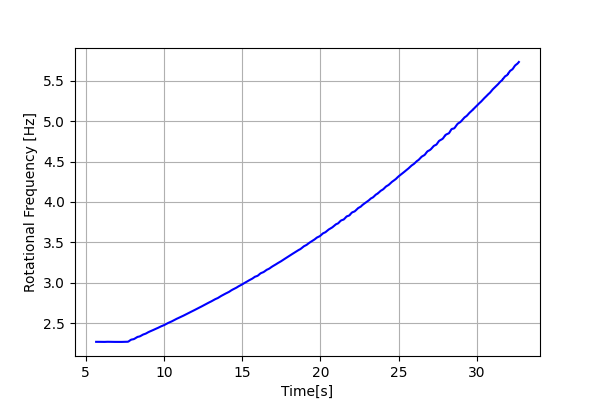

In [4]:
plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t2,fr_m_s/(2*np.pi*0.46),color='blue')
#plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Rotational Frequency [Hz]')
plt.grid(True)
print('Min vel [m/s]:',np.min(fr_m_s),'Min vel [km/h]:',3.6*np.min(fr_m_s), 'Min freq [Hz]:', np.min(fr_m_s)/(2*np.pi*0.46))
print('Max vel [m/s]:',np.max(fr_m_s),'Max vel [km/h]:',3.6*np.max(fr_m_s), 'Max freq [Hz]:', np.max(fr_m_s)/(2*np.pi*0.46))

In [5]:
def gen_G(f_fail, fs, N, Λ=10, D_lambda=1/16):
    K=int(Λ/D_lambda)
    Ts=1/fs
    λs=np.arange(0,Λ,D_lambda)
    G=np.zeros((K,N),dtype=np.complex128)
    for k in range(K):
        G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))
    return G

def calc_Xlambda(G, Sx):
    return (1/Sx.shape[0])*np.dot(G, Sx)

def matricial_IGD(f_fail, fs, Sx_env, Λ=10, D_lambda=1/16):
    G=gen_G(f_fail, fs, Sx_env.shape[0], Λ, D_lambda)
    Sx_env=Sx_env-np.mean(Sx_env)
    Sx_env_analytic=signal.hilbert(Sx_env)
    X_lambda = calc_Xlambda(G, Sx_env_analytic)
    return X_lambda

####  Wheel Flat
##### Index 0: Constant Speed 20 km/h, L=30 mm
##### Index 1: Constant Speed 20 km/h, L=60 mm
##### Index 2: Speed Increases Linearly from 20 to 60 km/h, L=30 mm

In [6]:
index = 2

t = WF_Sx[index]['t [s]'].to_numpy()
az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

print('Mean az no flat:',np.mean(az_no_flat))
print('Mean az flat:', np.mean(az_with_flat))

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
#fs=1/np.mean(np.diff(t))
print('Sampling freq:',fs,'Hz')
N=len(t)
n=np.arange(N)
print('Number of samples:', N)
print('Initial time:',t[0],'s')

r=0.46
print('Radius:',r,'m')

if index<2:
    v=20e3/3600
    print('Lineal velocity:',v,'m/s')
    
    fr=v/(2*np.pi*r)
    f_fail=fr*np.ones((N,1))
    print('Rotational freq:',fr,'Hz')


Mean az no flat: -9.809274950853673
Mean az flat: -9.802142279915559
Sampling freq: 1000.0 Hz
Number of samples: 27001
Initial time: 5.67 s
Radius: 0.46 m


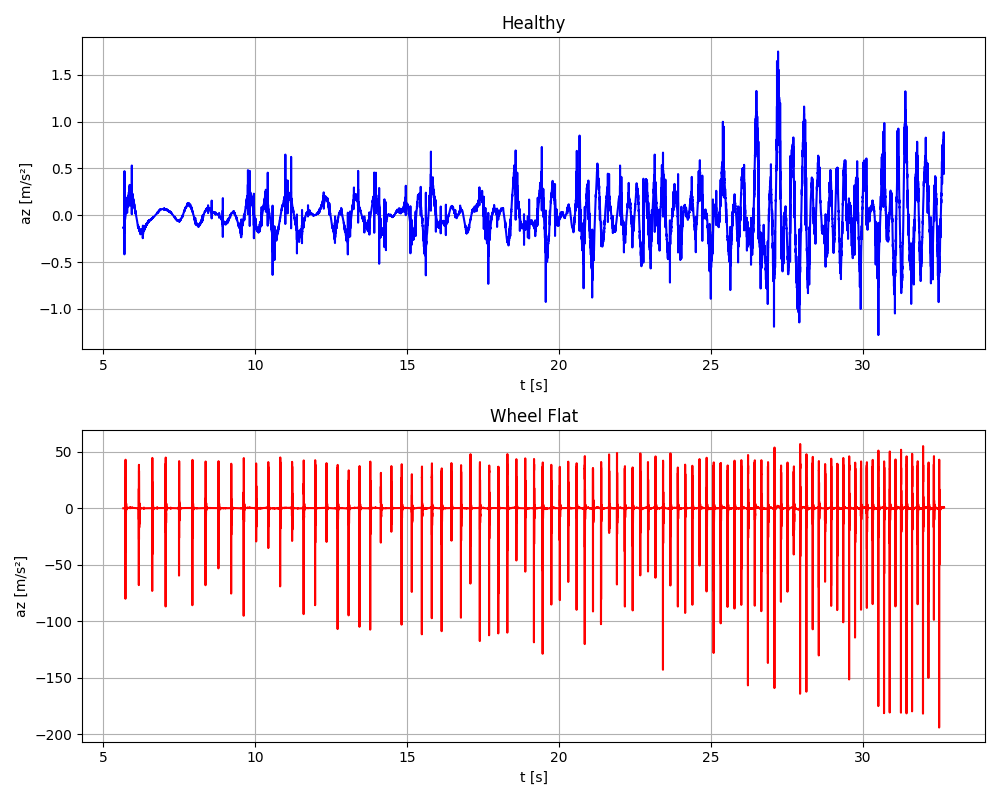

In [7]:
# Crear los subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Primer subplot: t vs az_no_flat_array
axs[0].plot(t, az_no_flat, label='Healthy', color='b')
axs[0].set_title('Healthy')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('az [m/s²]')
axs[0].grid(True)
#axs[0].legend()

# Segundo subplot: az_no_flat_array
axs[1].plot(t,az_with_flat, label='Wheel Flat', color='r')
axs[1].set_title('Wheel Flat')
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('az [m/s²]')
axs[1].grid(True)
#axs[1].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

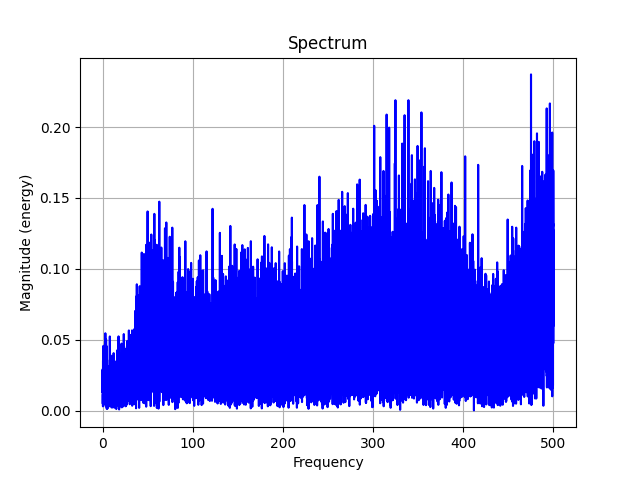

Max freq: 475.09351505499797


In [8]:
plt.close('all')
%matplotlib widget 
plt.title("Spectrum")
spectrum=plt.magnitude_spectrum(az_with_flat, Fs=fs, color='blue')
if index<2:
    for i in range(0, 50):
        plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
plt.show()

print('Max freq:',spectrum[1][np.argmax(spectrum[0])])

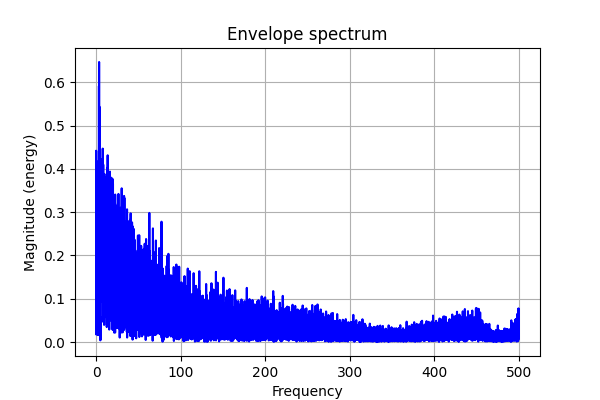

In [9]:
plt.close('all')
Sx_flat_env=np.abs(signal.hilbert(az_with_flat))
%matplotlib widget 
#%matplotlib inline
plt.figure(figsize=(6,4))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_flat_env-np.mean(Sx_flat_env), Fs=fs, color='blue')
if index<2:
    for i in range(1, 15):
        plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
#plt.savefig('prueba_rm.pdf',bbox_inches='tight')
plt.show()

---

In [10]:
t=[]
Sx_no_flat=[]
Sx_flat=[]
f_fail=[]

for index in range(3):
    t.append(WF_Sx[index]['t [s]'].to_numpy())
    az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
    az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

    az_no_flat = az_no_flat - np.mean(az_no_flat)
    az_with_flat = az_with_flat - np.mean(az_with_flat)

    Sx_no_flat.append(np.abs(signal.hilbert(az_no_flat)))
    Sx_flat.append(np.abs(signal.hilbert(az_with_flat)))

    if index < 2:
        v=20e3/3600
        r=0.46
        fr=v/(2*np.pi*r)
        f_fail.append(fr*np.ones((N,1)))
    else:
        f_fail.append(fr_m_s/(2*np.pi*r))

fs=1e3
N=len(t[0])
n=np.arange(N)

Λ=10
D_lambda=1/16
λs=np.arange(0,Λ,D_lambda)

In [11]:
print(np.array_equal(Sx_no_flat[0], Sx_no_flat[1]))
print(np.array_equal(Sx_no_flat[0], Sx_no_flat[2]))

True
False


In [12]:
X_lambda_0 = matricial_IGD(f_fail[0], fs, Sx_flat[0],Λ,D_lambda)
X_lambda_1 = matricial_IGD(f_fail[1], fs, Sx_flat[1],Λ,D_lambda)
X_lambda_2 = matricial_IGD(f_fail[2], fs, Sx_flat[2],Λ,D_lambda)

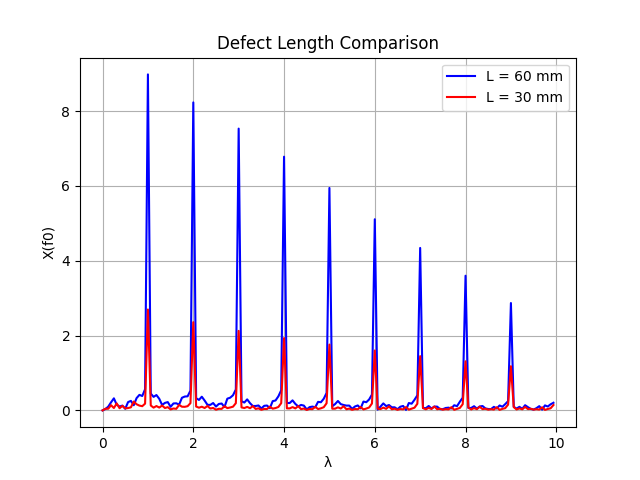

In [13]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_1),color='b')
plt.plot(λs,np.abs(X_lambda_0),color='r')
plt.legend(['L = 60 mm','L = 30 mm'])
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Defect Length Comparison") 
plt.grid(True)

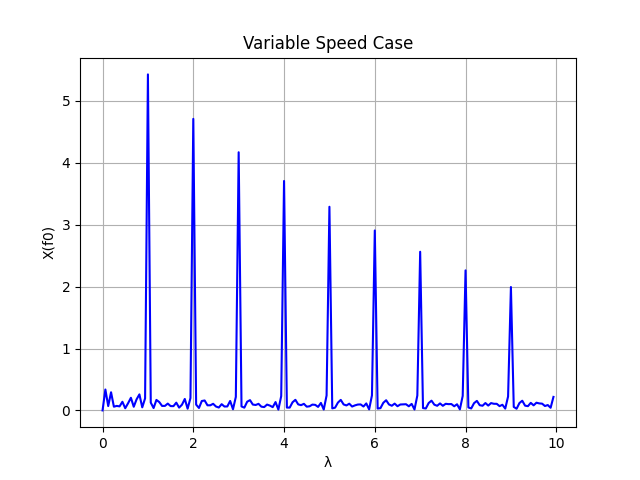

In [14]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_2),color='b')
plt.title("Variable Speed Case") 
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.grid(True)

In [15]:
X_lambda_no0 = matricial_IGD(f_fail[0], fs, Sx_no_flat[0],Λ,D_lambda)
#X_lambda_no1 = matricial_IGD(f_fail[1], fs, Sx_no_flat[1],Λ,D_lambda)
X_lambda_no2 = matricial_IGD(f_fail[2], fs, Sx_no_flat[2],Λ,D_lambda)

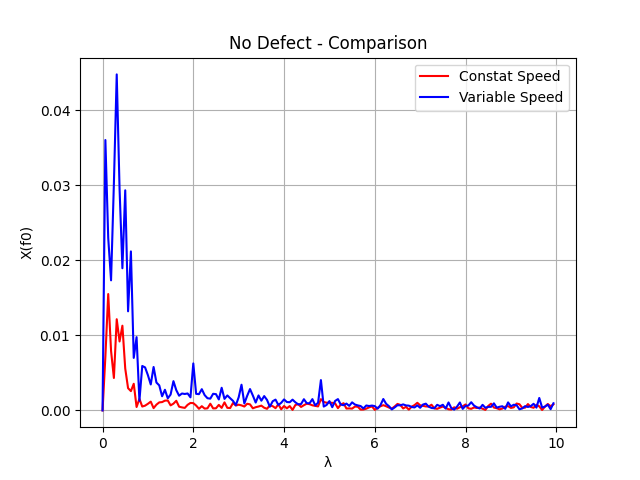

In [16]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_no0),color='r',label='Constat Speed')
plt.plot(λs,np.abs(X_lambda_no2),color='b',label='Variable Speed')
plt.legend()
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("No Defect - Comparison") 
plt.grid(True)

#### Constant speed L=30mm

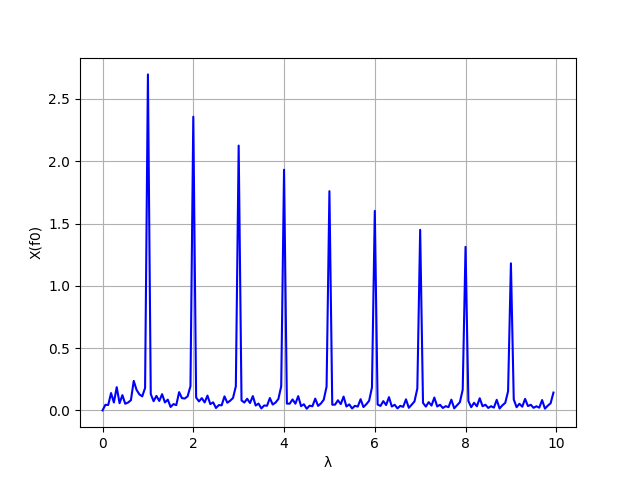

In [21]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

#plt.plot(λs,np.abs(X_lambda_1),color='b')
plt.plot(λs,np.abs(X_lambda_0),color='b')
#plt.legend(['L = 60 mm','L = 30 mm'])
plt.xlabel('λ')
plt.ylabel('X(f0)')
#plt.title("Defect Length Comparison") 
plt.grid(True)

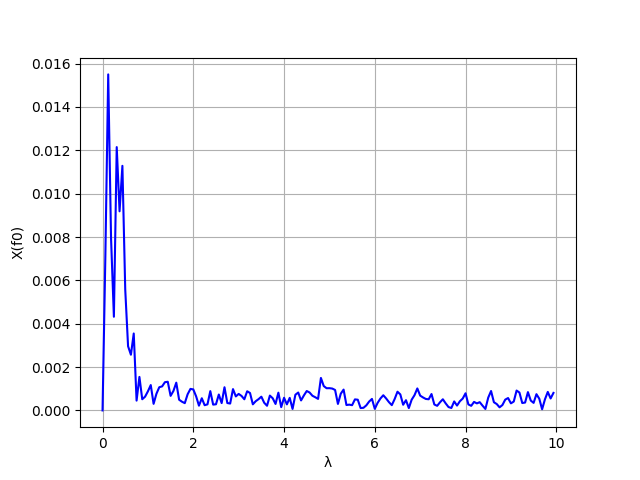

In [22]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_no0),color='b',label='Constat Speed')
#plt.plot(λs,np.abs(X_lambda_no2),color='b',label='Variable Speed')
#plt.legend()
plt.xlabel('λ')
plt.ylabel('X(f0)')
#plt.title("No Defect - Comparison") 
plt.grid(True)